In [1]:
!pip install -q transformers accelerate datasets

In [2]:
import transformers
transformers.__version__


'4.57.2'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the datatset

In [4]:
import json
import pandas as pd

json_path = "/content/drive/MyDrive/ISE547/Dataset/gpt2_notes_corpus.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.shape, df.head()


((260600, 8),
     row_id  subject_id   hadm_id            chartdate            charttime  \
 0  1831110       10826  127342.0  2182-09-14 00:00:00  2182-09-14 06:51:00   
 1  1831111       10826  127342.0  2182-09-14 00:00:00  2182-09-14 13:38:00   
 2  1831112       10826  127342.0  2182-09-14 00:00:00  2182-09-14 14:06:00   
 3  1831156       10838  162885.0  2199-08-02 00:00:00  2199-08-02 02:07:00   
 4  1827508       10576  103905.0  2113-07-03 00:00:00  2113-07-03 04:11:00   
 
         category description  \
 0  Nursing/other      Report   
 1  Nursing/other      Report   
 2  Nursing/other      Report   
 3  Nursing/other      Report   
 4  Nursing/other      Report   
 
                                                 text  
 0  NURSING PROGRESS NOTE\nAGREE W/ ABOVE NOTE.  P...  
 1  Neonatology Attending Progress Note:\nDOL #58\...  
 2  Nursing Progress and Discharge Note\n\n9 A/B's...  
 3  NPN 1900-0700\n\n\nPAR:  Parents in to visit a...  
 4  1900-0730 NPN\n\n8 CV\n\nR

### Subset Selection: 20,000 Notes Used for Fine-Tuning

In [5]:
N = 20000

if len(df) > N:
    df_work = df.sample(n=N, random_state=42).reset_index(drop=True)
else:
    df_work = df.copy()

df_work.shape


(20000, 8)

In [6]:
import re

def clean_note_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = re.sub(r"\[\*\*.*?\*\*\]", " ", text)

    text = re.sub(r"^[A-Z \/\-]+NOTE\s*\n", "", text, flags=re.MULTILINE)

    text = re.sub(r"[-_=]{3,}", " ", text)

    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"\n\s*\n\s*\n+", "\n\n", text)

    text = re.sub(r"[ \t]+(\n)", r"\1", text)
    return text.strip()

df_work["clean_text"] = df_work["text"].astype(str).apply(clean_note_text)
df_work = df_work[df_work["clean_text"].str.len() > 50].reset_index(drop=True)

df_work.shape


(19953, 9)

In [7]:
import os

corpus_path = "/content/drive/MyDrive/ISE547/Dataset/mimiciii_notes_clean_corpus.txt"

with open(corpus_path, "w", encoding="utf-8") as f:
    for note in df_work["clean_text"]:
        f.write(note + "\n\n<|note_sep|>\n\n")


In [8]:
os.path.getsize(corpus_path) / (1024 * 1024)


34.14513683319092

# Construct HuggingFace Dataset and create  splits

In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df_work[["clean_text"]])

dataset = dataset.train_test_split(test_size=0.1, seed=42)


train_valid = dataset["train"].train_test_split(test_size=0.1, seed=42)

dataset["train"] = train_valid["train"]
dataset["validation"] = train_valid["test"]



# Load the GPT-2 tokenizer and assign a padding token

In [10]:
from transformers import AutoTokenizer

model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

block_size = 256

def tokenize_function(examples):
    return tokenizer(
        examples["clean_text"],
        truncation=True,
        max_length=block_size,
    )

tokenized_ds = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["clean_text"],
)

tokenized_ds


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/16161 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/1796 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 16161
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1996
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1796
    })
})

# Load the GPT-2 model and configure the pad_token_id

In [11]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_name)
model.config.pad_token_id = tokenizer.pad_token_id


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Configure TrainingArguments and Trainer, then launch fine-tuning

In [17]:
from transformers import TrainingArguments

output_dir = "/content/drive/MyDrive/ISE547/Dataset/gpt2_finetuned_mimic_demo"

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    fp16=True,
    report_to="none",
)



In [13]:
from transformers import Trainer, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
)


In [14]:
train_result = trainer.train()


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,4.209500
100,3.495500
150,3.222800
200,3.128400
250,3.026600
300,2.865500
350,2.845400
400,2.787600
450,2.721900
500,2.612700


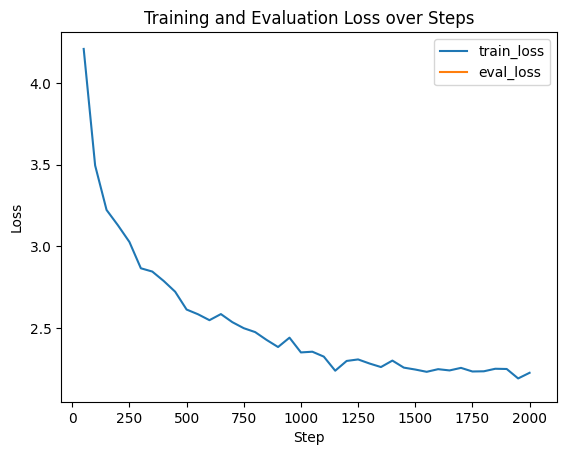

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

df = pd.DataFrame(log_history)

train_df = df[df["loss"].notna()][["step", "loss"]]
eval_df = df[df["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure()
plt.plot(train_df["step"], train_df["loss"], label="train_loss")
plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval_loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss over Steps")
plt.show()


# Save the fine-tuned model and tokenizer

In [18]:
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/ISE547/Dataset/gpt2_finetuned_mimic_demo/tokenizer_config.json',
 '/content/drive/MyDrive/ISE547/Dataset/gpt2_finetuned_mimic_demo/special_tokens_map.json',
 '/content/drive/MyDrive/ISE547/Dataset/gpt2_finetuned_mimic_demo/vocab.json',
 '/content/drive/MyDrive/ISE547/Dataset/gpt2_finetuned_mimic_demo/merges.txt',
 '/content/drive/MyDrive/ISE547/Dataset/gpt2_finetuned_mimic_demo/added_tokens.json',
 '/content/drive/MyDrive/ISE547/Dataset/gpt2_finetuned_mimic_demo/tokenizer.json')

# Compute perplexity (Base GPT-2 vs Fine-Tuned GPT-2)

### Evaluate the Base GPT-2 model on the same test set

In [19]:
import math
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer

base_model = AutoModelForCausalLM.from_pretrained(model_name)
base_model.config.pad_token_id = tokenizer.pad_token_id

base_args = TrainingArguments(
    output_dir=output_dir + "_base_eval",
    per_device_eval_batch_size=2,
    dataloader_drop_last=True,
    report_to="none",
)

base_trainer = Trainer(
    model=base_model,
    args=base_args,
    eval_dataset=tokenized_ds["test"],
    data_collator=data_collator,
)

base_metrics = base_trainer.evaluate()
print(base_metrics)

base_perplexity = math.exp(base_metrics["eval_loss"])
print("Base GPT-2 Perplexity:", base_perplexity)



{'eval_loss': 5.214369297027588, 'eval_model_preparation_time': 0.0022, 'eval_runtime': 32.2752, 'eval_samples_per_second': 61.843, 'eval_steps_per_second': 30.922}
Base GPT-2 Perplexity: 183.8958007681878


### Evaluate the Fine-Tuned GPT-2 model on the test set

In [20]:
ft_metrics = trainer.evaluate(eval_dataset=tokenized_ds["test"])
print(ft_metrics)

ft_perplexity = math.exp(ft_metrics["eval_loss"])
print("Fine-tuned GPT-2 Perplexity:", ft_perplexity)



{'eval_loss': 2.15079665184021, 'eval_runtime': 26.8513, 'eval_samples_per_second': 74.335, 'eval_steps_per_second': 37.168, 'epoch': 2.0}
Fine-tuned GPT-2 Perplexity: 8.59170026534953


# Generate Before/After text comparisons for qualitative evaluation

In [21]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
base_model = base_model.to(device)
model = model.to(device)   # fine-tuned

def generate_text(model, tokenizer, prompt, max_new_tokens=150,
                  temperature=0.6, top_p=0.9):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            repetition_penalty=1.2,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


prompts = [
    "ASSESSMENT AND PLAN:\nThe patient is a 65-year-old male admitted to the ICU with septic shock. ",
    "DISCHARGE SUMMARY:\nChief Complaint: Shortness of breath\n History of Present Illness: The patient is a 53-year-old male with a history of hypertension who presented with... ",
    "ICU PROGRESS NOTE:\nOvernight events: The patient remained hemodynamically stable with no acute events. \nVitals(last 24h): ",
]

for i, p in enumerate(prompts, 1):
    print("=" * 80)
    print(f"PROMPT {i}:\n{p}")
    print("-" * 80)

    print("[Base GPT-2]")
    base_out = generate_text(base_model, tokenizer, p)
    print(base_out)
    print("-" * 80)

    print("[Fine-tuned GPT-2]")
    ft_out = generate_text(model, tokenizer, p)
    print(ft_out)
    print("\n")


PROMPT 1:
ASSESSMENT AND PLAN:
The patient is a 65-year-old male admitted to the ICU with septic shock. 
--------------------------------------------------------------------------------
[Base GPT-2]
ASSESSMENT AND PLAN:
The patient is a 65-year-old male admitted to the ICU with septic shock.  He has been in intensive care since December 2012 and was discharged from hospital on March 17, 2013 after being found unconscious at 3am (the same day as his diagnosis) by emergency room staff who reported him missing for approximately an hour while waiting tables were open - apparently because he had not eaten or drunk yet! In other words there are no signs of dehydration during treatment but rather just some residual sweat that does show up when you wash your hands afterwards...   He will need 24 hours' rest before returning home so it might be necessary if this happens again soon!! The only thing we have left right now though would be 1/3rds worth of ice cream I am going through here which cou